In [2]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

# Test 1: Scalar ODE with 2 parameter

$$ y' = \beta exp(-\beta t) - \alpha y \quad y(0) = 0 $$

In [3]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_ics = 1
n_odeparams = 2

#Times to evaluate the solution
times = np.arange(0.25,8,1)

#Instantiate the ODEModel
model_1 = ODEModel(odefunc = test_ode_func_2, 
                   y0 = 0,
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_ics = n_ics,
                    n_odeparams = n_odeparams)

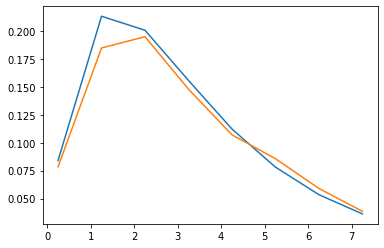

In [8]:
#Simulate the data and create data to learn from
sims, sens = model_1.simulate([0.4,1,0])


Y = scipy.stats.lognorm.rvs(s = 0.1, scale = sims)


plt.plot(times, sims)
plt.plot(times,Y)




In [10]:
# Now instantiate the theano custom ODE op
my_ODEop = ODEop(model_1)

all_params __str__ = [0.79788456 0.79788456 0.79788456]
ode_sol __str__ = [0.81699774 0.66218068 0.43068573 0.25359997 0.14105962 0.07561475
 0.0394955  0.02023703]
forward __str__ = [[-0.20211895]
 [-0.41221684]
 [-0.84237661]
 [-1.37199719]
 [-1.95857267]
 [-2.58210386]
 [-3.23156844]
 [-3.90024129]]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, y0, alpha, beta]
Sampling 4 chains: 100%|██████████| 12000/12000 [15:39<00:00,  3.66draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


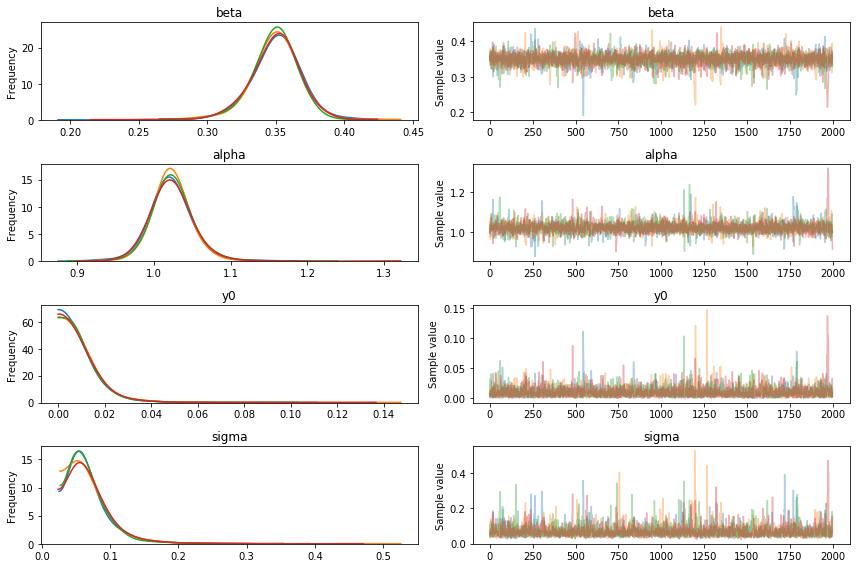

In [11]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    beta = pm.HalfNormal('beta',1)
    alpha = pm.HalfNormal('alpha',1)
    
    y0 = pm.HalfNormal('y0',1)
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([beta,alpha, y0],axis=0)
    pprint = tt.printing.Print('all_params')(all_params)
    
    ode_sol = my_ODEop(all_params)
    oprint = tt.printing.Print('ode_sol')(ode_sol)
    
    forward = ode_sol.reshape(Y.shape)
    fprint = tt.printing.Print('forward')(pm.math.log(forward))
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
#     Y_obs = pm.Normal('Y_obs', mu=forward, sd=sigma, observed=Y)
#     Y_obs = pm.Lognormal('Y_obs', mu=forward, sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, chains = 4, init='adapt_diag', target_accept = 0.99)

pm.traceplot(trace)

plt.show()

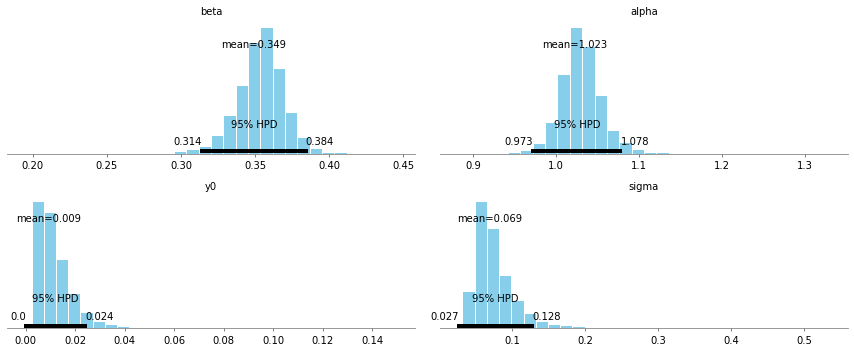

In [12]:
pm.posteriorplot.plot_posterior(trace);


In [13]:
print(pm.gelman_rubin(trace))

print(pm.effective_n(trace))

{'beta': 1.0001977821014407, 'alpha': 1.0005947555209111, 'y0': 0.9999118464786835, 'sigma': 0.9999663081074125}
{'beta': 2365.4573147623078, 'alpha': 2424.0142785287135, 'y0': 2597.6437619164676, 'sigma': 1869.4334779138799}


In [14]:
with first_model:
    yppc = pm.sample_ppc(trace)

100%|██████████| 2000/2000 [01:07<00:00, 32.02it/s]


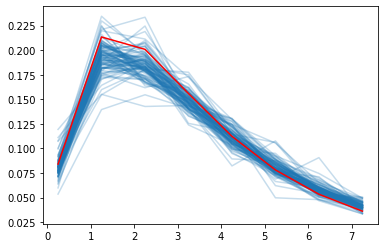

In [32]:
Y_obs  = yppc['Y_obs']

for i in range(100):
    
    plt.plot(times, Y_obs[i].ravel(), alpha = 0.25, color = 'C0')
    
plt.plot(times,sims, color = 'red')